In [21]:
import os
import json
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm
from matplotlib import patches

In [2]:
coco_json = json.load(open('../dataset/new_train.json'))
images = coco_json['images']
annotations = coco_json['annotations']
categories = {k['id']:k['name'] for k in coco_json['categories']}
rev_categories = {v:k for k,v in categories.items()}
COLOR_MAP = [
    (171, 222, 230), (203, 170, 203), (255, 255, 181), (255, 204, 182), (243, 176, 195),
    (151, 193, 169), (254, 225, 232), (198, 219, 218), (255, 150, 138), (85, 203, 205)
]

### Extract candidate image_id

candidates : number of bbox per image <= 3

In [4]:
num_of_bbox_per_image = defaultdict(list)
for image in images:
    candits = [k for k in annotations if k['image_id'] == image['id']]
    if len(candits) <= 3:
        num_of_bbox_per_image[len(candits)].append(image['id'])
        

In [5]:
candit_image_ids = []
for k, v in num_of_bbox_per_image.items():
    candit_image_ids.extend(v)

In [6]:
print("length of candidates: ", len(candit_image_ids))

length of candidates:  3042


### Extract object

target: metal, glass, battery, paper pack, clothing

In [7]:
metal_objects = []
glass_objects = []
battery_objects = []
paperpack_objects = []
clothing_objects = [] 

In [8]:
object_dict = {
    0: [], # metal_objects
    1: [], # glass_objects
    2: [], # battery_objects
    3: [], # paperpack_objects
    4: [] # clothing_object
}

In [9]:
def extract_objects(cls_name: str) -> list:
    total_objects = []
    
    candits = [k for k in annotations if k['category_id'] == cls_name]
    candits = sorted(candits, key=lambda x: x['image_id'])
    for _, candit in tqdm(enumerate(candits)):
        obj = {}
        image_data = images[candit['image_id']]
        bbox = tuple(candit['bbox'])
        x1, y1, x2, y2 = bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]
        
        image = Image.open(os.path.join('../dataset', image_data['file_name']))
        w, h = image.size
        cropped_image = image.crop(tuple([max(x1-1, 0), max(y1-1, 0), min(x2+1, w), min(y2+1, h)]))
        cropped_image = image.crop(tuple([x1, y1, x2, y2]))
        
        obj['image_id'] = candit['image_id']
        obj['category_id'] = candit['category_id']
        obj['bbox'] = bbox
        obj['area'] = candit['area']
        obj['iscrowd'] = candit['iscrowd']
        obj['pil_obj'] = cropped_image
        total_objects.append(obj)
        
    return total_objects

In [10]:
for i, cls_name in enumerate(["Metal", "Glass", "Battery", "Paper pack", "Clothing"]):
    cls_name = rev_categories[cls_name]
    object_dict[i] = extract_objects(cls_name)

12it [00:00, 118.92it/s]

978it [00:07, 138.53it/s]
977it [00:06, 152.86it/s]
160it [00:00, 166.94it/s]
908it [00:06, 139.61it/s]
492it [00:03, 150.08it/s]


In [11]:
object_dict[0][0]

{'image_id': 1,
 'category_id': 3,
 'bbox': (0.0, 407.4, 57.6, 180.6),
 'area': 10402.56,
 'iscrowd': 0,
 'pil_obj': <PIL.Image.Image image mode=RGB size=58x181>}

In [12]:
candit_image_ids = sorted(candit_image_ids)

In [13]:
seed = 2024
random.seed(seed)
np.random.seed(seed)

In [14]:
if not os.path.exists("../dataset/new_train"):
    os.makedirs("../dataset/new_train", exist_ok=True)

new_coco = {}
new_images = []
new_annotations = []
new_categories = coco_json['categories']

annot_idx = 0
for idx, image in tqdm(enumerate(images)):
    new_img = {}
    new_img['id'] = idx
    new_img['file_name'] = "new_"+image['file_name']
    new_img['height'] = image['height']
    new_img['width'] = image['width']
    new_images.append(new_img)
    
    candits = list(filter(lambda x: x['image_id'] == image['id'], annotations))
    for annot in candits:
        new_annot = {}
        new_annot['id'] = annot_idx
        new_annot['image_id'] = idx
        new_annot['category_id'] = annot['category_id']
        new_annot['bbox'] = annot['bbox']
        new_annot['area'] = annot['area']
        new_annot['iscrowd'] = annot['iscrowd']
        new_annotations.append(new_annot)
        annot_idx += 1
        
    _annot_bboxs = [k['bbox'] for k in candits]
    _annot_bboxs = [[k[0], k[1], k[0]+k[2], k[1]+k[3]] for k in _annot_bboxs]
    origin_img = Image.open(os.path.join('../dataset', image['file_name']))

    # random insert
    if idx in candit_image_ids:
        i = 0
        while i < 2:
            # duplicate without bbox 
            new_annot = {}
            random_obj_cls = object_dict[random.randint(0, 4)]
            random_obj = random_obj_cls[random.randint(0, len(random_obj_cls)-1)]
            
            new_annot['id'] = annot_idx
            new_annot['image_id'] = idx
            new_annot['category_id'] = random_obj['category_id']
            new_annot['area'] = random_obj['area']
            new_annot['iscrowd'] = random_obj['iscrowd']
            
            # find random position
            x1, y1, w, h = random_obj['bbox']
            roi_x1, roi_x2 = 0, new_img['width'] - (w + 1)
            roi_y1, roi_y2 = 0, new_img['height'] - (h + 1)
            
            new_ptx = random.randint(roi_x1, int(roi_x2))
            new_pty = random.randint(roi_y1, int(roi_y2))
            
            flag = False
            for _bbox in _annot_bboxs:
                if new_ptx < _bbox[0] and new_ptx + w > _bbox[2] and new_pty < _bbox[1] and new_pty + h > _bbox[3]:
                    flag = True
                    break
            if flag:
                continue
  
            new_annot['bbox'] = [new_ptx, new_pty, w, h]
            _annot_bboxs.append([new_ptx, new_pty, new_ptx + w, new_pty + h])
            new_annotations.append(new_annot)
            
            # paste
            origin_img.paste(random_obj['pil_obj'], (new_ptx, new_pty))
            annot_idx += 1
            i += 1
            
    origin_img.save(os.path.join("../dataset", new_img['file_name']))

4883it [01:32, 52.93it/s]


In [15]:
new_coco['images'] = new_images
new_coco['annotations'] = new_annotations
new_coco['categories'] = new_categories
    
with open('../dataset/added_new_train.json', 'w') as f:
    json.dump(new_coco, f)

In [16]:
def vis_bar_plot(idx: np.ndarray, count: list, fig_w: int, fig_h: int, text_h: int, title: str):
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))
    ax.bar(
        idx, count, width=0.7, 
        ec='red', lw=2, color="tomato"
    )

    for i, v in zip(idx, count):
        ax.text(
            i, v+text_h, str(v), ha='center', va='bottom',
            fontweight='bold', fontsize=10
        )

    ax.set_title(title, fontsize=14)
    plt.show()

In [17]:
new_coco_json = json.load(open('../dataset/added_new_train.json'))
new_images = new_coco_json['images']
new_annotations = new_coco_json['annotations']
new_categories = {k['id']:k['name'] for k in new_coco_json['categories']}

In [18]:
len(new_annotations)

30428

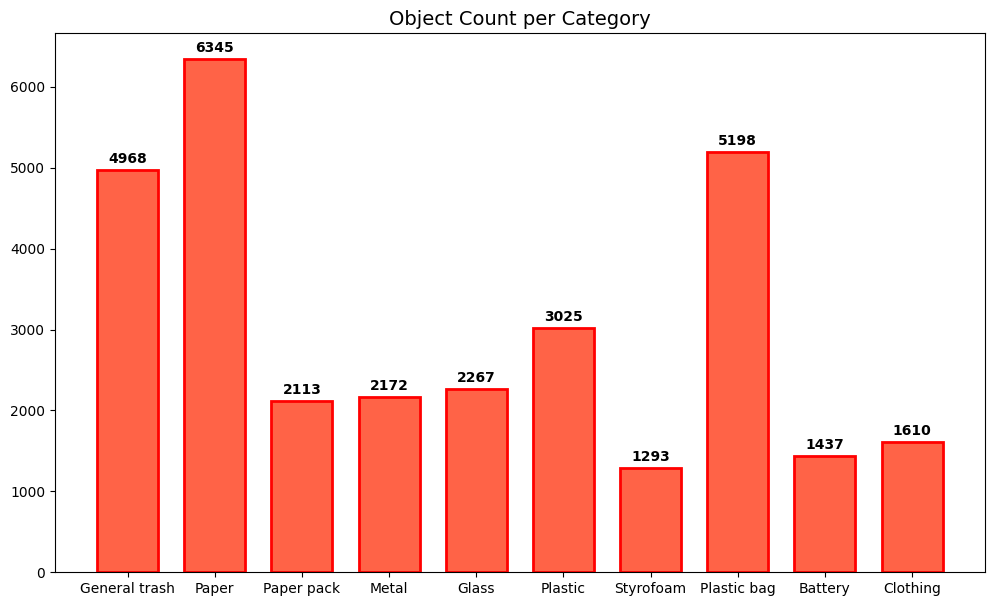

In [19]:
idx = np.array([categories[i] for i in range(len(new_coco_json['categories']))])
count = [len([annot for annot in new_coco_json['annotations'] if annot['category_id'] == i]) for i in range(len(new_coco_json['categories']))]
vis_bar_plot(idx, count, 12, 7, 50, "Object Count per Category")


In [26]:
def random_vis(root_dir: str, rows: int, cols: int):
    idxs = random.sample(list(range(len(new_images))), rows*cols)
    fig, axes = plt.subplots(rows, cols, figsize=(20, 20))

    for i, idx in enumerate(idxs):
        r, c = i//cols, i%cols
        img_path = os.path.join(root_dir, new_images[idx]['file_name'])
        img = Image.open(img_path).convert("RGB")
        candits = [k for k in new_annotations if k['image_id'] == new_images[idx]['id']]
        
        for candit in candits:
            bbox = candit['bbox']
            bbox = [int(k) for k in bbox]
            cat_id = candit['category_id']
            cat_name = categories[cat_id]
            color = [num/255 for num in COLOR_MAP[cat_id%10]]
            bbox_rect = patches.Rectangle(
                (bbox[0], bbox[1]), 
                bbox[2], bbox[3],       
                linewidth=3,        
                edgecolor=color,        
                facecolor='none'        
            )
            axes[r][c].add_patch(bbox_rect)
            axes[r][c].annotate(
                cat_name, 
                (bbox[0]+3, bbox[1]-10), 
                color='black', 
                weight='bold', 
                fontsize=10,
                backgroundcolor=color
            )
            
        axes[r][c].imshow(img)
        axes[r][c].axis('off')
        axes[r][c].set_title(img_path.split('/')[-1], fontsize=20)
    
    plt.tight_layout()
    plt.show()

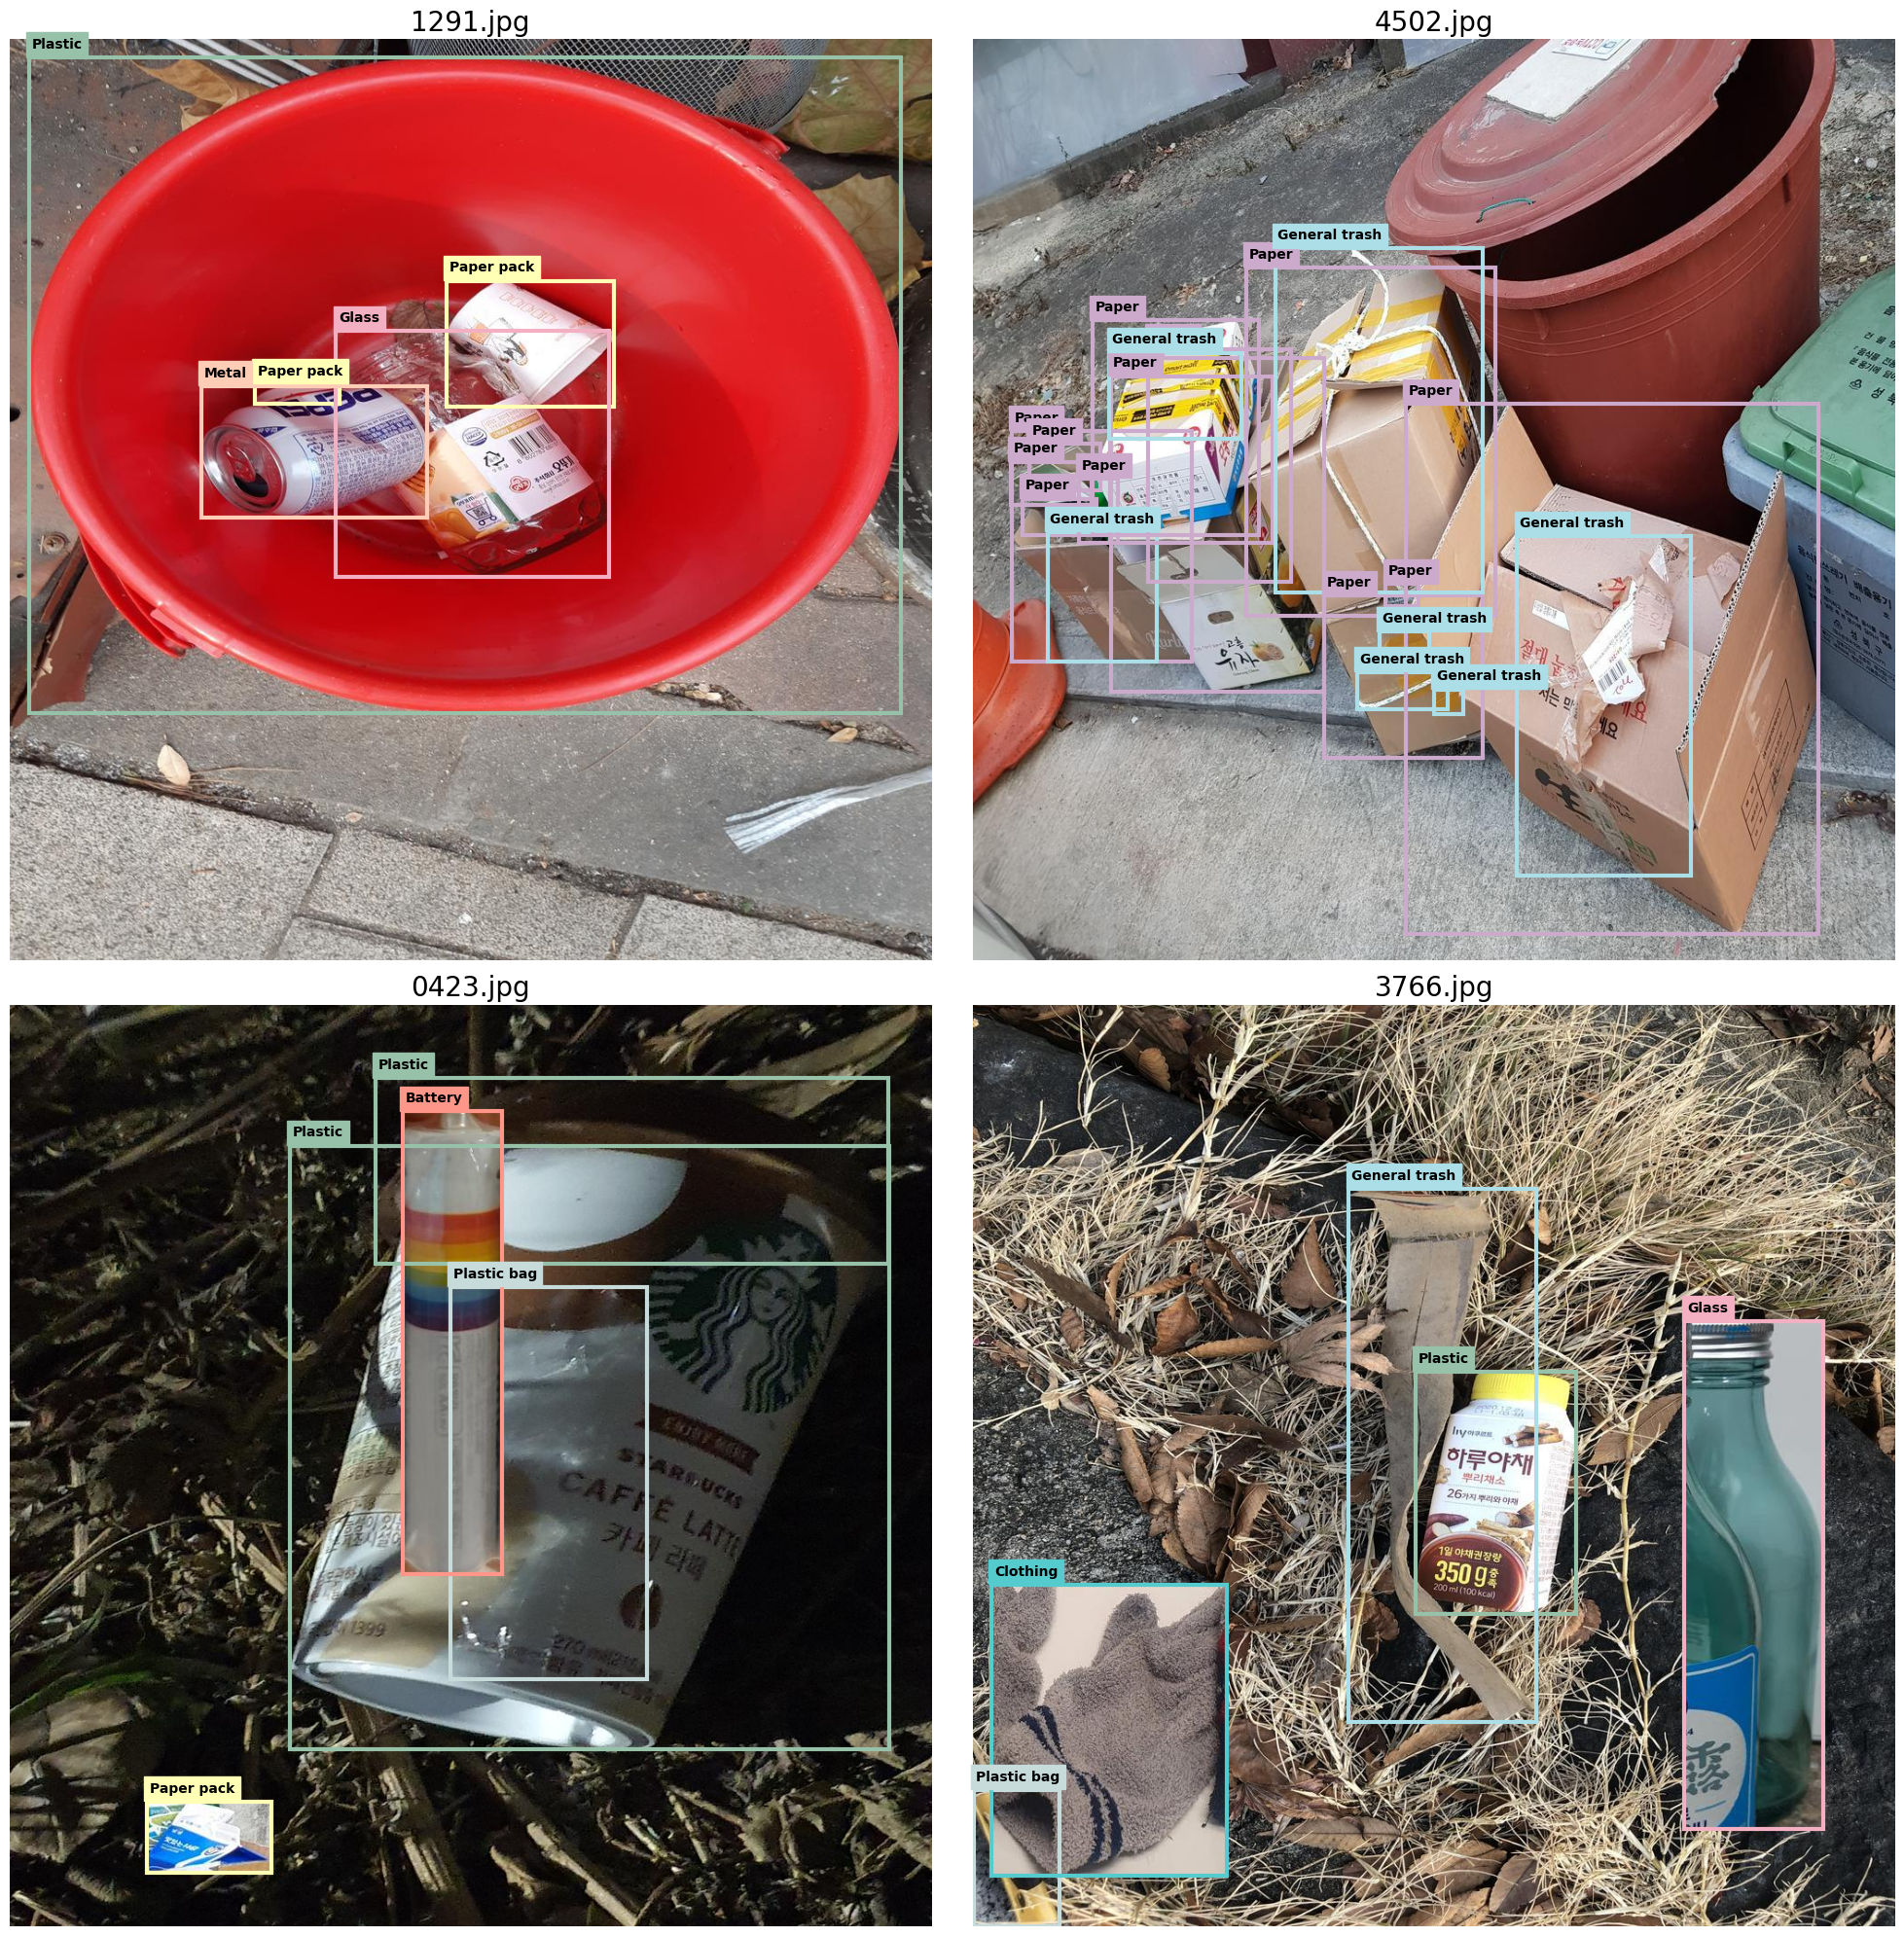

In [27]:
random_vis("../dataset", 2, 2)